# Introduction to Data Science 
# Lecture 28: Ratings, Rankings, and Elections
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture, we'll study methods for ratings, rankings, and elections. In particular, we'll discuss

* methods and applications for rating/ranking 
* the least squares method for rating, a.k.a. HodgeRank 
* rating/ranking in sports
* elections and Arrow's impossibility theorem 

Recommended Reading:
* A. N. Langville and C. D. Meyer, [Who's \#1?: The Science of Rating and Ranking](https://doi.org/10.1515/9781400841677), Princeton University Press (2012).
* C. Borgers, [Mathematics of Social Choice](https://doi.org/10.1137/1.9780898717624), SIAM (2010).


In [1]:
# imports and setup
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')


## Ratings vs. Rankings

+ A *rating* assigns each item a numerical score. 
+ A *ranking* refers to a rank-ordered list of items. 

Rankings can be obtained from ratings by sorting. 

** Applications involving rating/ranking: ** 
+ Sports (football, tennis, baseball, chess, ...) 
+ Ranking webpages (Google)
+ Online e-commerce (Amazon, Netflix, ...)
+ College Rankings (US News, ...)
+ Social networks (Facebook, ...)
+ ...

Below, it will be convenient to use the language of sports to describe rating/ranking methods (*e.g.*, items to be ranked are teams). But, keep in mind that the methods discussed are more general than sports applications. 

**Rating/ranking methods:**
+ Least squares methods (a.k.a. $\ell^2$ norm, HodgeRank, Massey, Colley, ...)
+ Least absolute deviation ($\ell^1$ norm)
+ Probablistic methods such as the Bradley-Terry and Thurstone models
+ Methods based on the Perron-Frobenius theorem (Keener, PageRank,...)
+ Elo's method
+ ...


There are many different methods for rating/ranking. The [masseyratings.com](http://www.masseyratings.com/cf/compare.htm) website has a comparison of 103 different rankings for NCAA college football. 

The simplest rating method rates teams based on their *winning percentage*. This is the method used in Major League Baseball (MLB). One drawback of this method is that it fails to take into account the strength of the teams' opponent (strength of schedule). 

We'll focus on the **Least squares** or **HodgeRank** method, which is perhaps the simplest method that does take into account the strength of opponents. 



## Least Squares Rating

**Data:** We start with a pairwise comparison dataset, consisting of 
+ a collection of $n$ items to be ranked,  $V =\{ i\}_{i=1}^n$
+ pairwise comparisons, $y_{i,j}$, comparing items $i$ and $j$
+ confidence weights, $w_{i,j}$, in the comparison between items $i$ and $j$.  

It might be the case that not all items in the dataset have been compared. For such pairs, $(i,j)$, we set the confidence weights $w_{i,j}=0$. We also require that the pairwise comparisons are anti-symmetric, *i.e.*, 
$y_{i,j} = - y_{j,i}$. This simply means that item $i$ is preferred to item $j$ as much as item $j$ is dispreferred to item $i$. 


**Goal:** Find a rating $\phi_i$ for $i\in V$ such that 
$$
\phi_i - \phi_j \approx y_{i,j}, 
$$
where the comparisons with high confidences are matched more closely than comparisons with a low confidence (as measured by $w_{i,j}$). 


One way to make this problem precise is to define the function 
$$
J(\phi) = \sum_{i,j} w_{i,j} (\phi_i - \phi_j - y_{i,j})^2,
$$ 
and then to minimize
$$
\min_{\phi\in \mathbb R^n} \ J(\phi). 
$$
A minimizer of this problem is  called the least squares rating or HodgeRank estimate. Note that in the objective function $J(\phi)$, we pay a penalty proportional to $w_{i,j}$ when $\phi_i - \phi_j \neq y_{i,j}$; the solution minimizes this cost. 


## Interpretation on a directed graph
We can interpret this problem on a directed graph as follows. A vertex is assigned to each item to be ranked. We then add directed edges (arcs) to the graph between each vertex pair for which there is a pairwise comparison.  The orientation of the arcs is chosen based on the signs of the pairwise preferences. If $y_{i,j}>0$, then our convention is choose the arc orientation $(i,j)$ instead of $(j,i)$. Thus, the equation $\phi_i - \phi_j \approx y_{i,j}$ is enforcing the requirement that item $i$ is preferred to item $j$. We enumerate the arcs $A = \{k\}_{k=1}^m$. The pairwise comparisons and confidence weights are then viewed as functions on the arc set, $A$. Let $D = (V,A)$. The *arc-vertex incidence matrix* for $D$ is $B \in \mathbb R^{m\times n}$, with entries  
$$
B_{k,j} = \begin{cases}
1 & j = \text{head}(k) \\
-1 & j = \text{tail}(k) \\
0 & \text{otherwise}. 
\end{cases}
$$
We can use the matrix $B$ to rewrite the function $J$, in a very compact form:
$$
J(\phi) = \| B \phi - y \|_{2,w}^2. 
$$
Here, $\| \cdot \|_{2,w} $ is the $w$-weighted $\ell^2$-norm, $\| v \|_{2,w} = \sqrt{ \sum_{k} w_k v_k^2} = \sqrt{v^t W v}$, where $W = \text{diag}(w)$.

Thus, the least squares rating is the solution to the optimization problem
$$
\min_{\phi\in \mathbb R^n} \  \| B \phi - y \|_{2,w}^2 
$$

**Solution.** 
How do you solve the least squares problem? We can take the derivative and set it to zero to obtain the "normal equations". We write 
$$
J(\phi) = \phi^t B^t W B \phi - 2 y^t W B \phi + y^t W y. 
$$
Taking the gradient with respect to $\phi$, we obtain 
$$
0 = \nabla_\phi J = 2 B^t W B \phi - 2 B^t W y  \qquad \implies \qquad  B^t W B \phi = B^t W y. 
$$
Thus, the minimizer is a solution to this linear system of equations. 

**Interpretation.** 
The matrix, $B^t W B$, on the left-hand-side of this equation has a nice interpretation. 
This matrix, $\Delta_w = B^t W B$,  is called the *$w$-weighted graph Laplacian*. The unweighted version, $\Delta \colon V \to V$, has entries 
$$
 \Delta_{i,j} = \begin{cases}
\text{deg}(i) &  i = j \\
-1 & i \sim j \\
0 & \text{otherwise}
\end{cases}
$$
We can also write $\Delta = D - A$ where $D$ is the degree matrix and $A$ is the adjacency matrix. 
The $w$-weighted graph Laplacian has entries 
$$
( \Delta_w)_{i,j} = \begin{cases}
\text{deg}_w(i) & i = j \\
-w_{i,j} & \text{otherwise} 
\end{cases}
$$
Here we have used the convention that $w_{i,j}=0$ if $i$ and $j$ are not adjacent and $\text{deg}_w(i) = \sum_{j \in V} w_{i,j}$ are the $w$-weighted degrees. We can also write $\Delta = D_w - W$ where $D_w$ is the $w$-weighted degree matrix and $W$ is the weight matrix. 



## Least Squares Rating: toy example

We consider the following hypothetical sports problem. There are four football teams: Utah (U), BYU (Y), Colorado (C), and Idaho (I). Five games are played with the following results:

U vs Y: 20 - 10 

Y vs C: 7 - 10

U vs C: 10 -10

U vs I: 10 - 7

I vs Y: 7 - 7

We first construct the pairwise comparisons, $y_{i,j}$ defined by
$$
y_{i,j} = \frac{\text{points team $j$ scored - points team $i$ scored}}{\text{total points in game}}. 
$$

In [2]:
scores = np.array([(20, 10), (7, 10), (10, 10), (10, 7), (7, 7)])
print(scores)

y = (scores[:,1] - scores[:,0]) / (scores[:,0] + scores[:,1])
print(y)

[[20 10]
 [ 7 10]
 [10 10]
 [10  7]
 [ 7  7]]
[-0.33333333  0.17647059  0.         -0.17647059  0.        ]


We also number the teams.

In [3]:
teams = ['Utah (U)','BYU (Y)','Colorado (C)','Idaho (I)']
for i,t in enumerate(teams):
    print(str(i) + ': ' + t)


0: Utah (U)
1: BYU (Y)
2: Colorado (C)
3: Idaho (I)


Construct the arc-vertex incidence matrix
$$
B_{k,j} = \begin{cases}
1 & j = \textrm{head}(k) \\
-1 & j = \textrm{tail}(k) \\
0 & \textrm{otherwise}. 
\end{cases}
$$
This just keeps track of which teams have played which teams. 

In [4]:
B = np.zeros((5, 4))

B[0,1] = 1; B[0,0] =-1;
B[1,2] = 1; B[1,1] =-1; 
B[2,2] = 1; B[2,0] =-1; 
B[3,3] = 1; B[3,0] =-1; 
B[4,1] = 1; B[4,3] =-1; 
print(B)

# now we have enough information just to print the  game results 
for i,sc in enumerate(y):
    head = np.where(B[i,:]==1)[0][0]
    tail = np.where(B[i,:]==-1)[0][0]
    print(teams[head] + ' vs. ' + teams[tail] + ': ' +str(sc))


[[-1.  1.  0.  0.]
 [ 0. -1.  1.  0.]
 [-1.  0.  1.  0.]
 [-1.  0.  0.  1.]
 [ 0.  1.  0. -1.]]
BYU (Y) vs. Utah (U): -0.3333333333333333
Colorado (C) vs. BYU (Y): 0.17647058823529413
Colorado (C) vs. Utah (U): 0.0
Idaho (I) vs. Utah (U): -0.17647058823529413
BYU (Y) vs. Idaho (I): 0.0


We now use the *lstsq* function in the np.linalg library to find the least squares rating, solving the least squares problem, 
$$
\min_{\phi} \ \| B \phi - y \|^2. 
$$

In [5]:
sol = np.linalg.lstsq(B,y)
phi = sol[0]
print(phi)

[ 0.12745098 -0.12745098  0.08823529 -0.08823529]


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [6]:
ind = np.argsort(phi)
ind = np.flipud(ind)
sorted_phi = phi[ind]
sorted_teams = [teams[i] for i in ind]

for i,t in enumerate(sorted_teams):
    print(t + ': rating = ' + str(sorted_phi[i]))

Utah (U): rating = 0.12745098039215688
Colorado (C): rating = 0.08823529411764706
Idaho (I): rating = -0.08823529411764713
BYU (Y): rating = -0.12745098039215694


## College Football Primer

National Collegiate Athletic Association (NCAA) College Football is divided into two subdivisions: 
- Football Bowl Subdivision (FBS), formerly  Division I-A
- Football Championship Subdivision (FCS), formerly Division I-AA

We'll focus on the FBS. 

The FBS is further divided into 11 conferences, some of which have sub-divisions. For example, the University of Utah is in the South Division of the Pacific 12 (Pac-12) Conference. 

      A.  American Athletic Conference
           i) East Division
                Central Florida
                Cincinnati
                Connecticut
                East Carolina
                South Florida
                Temple
          ii) West Division
                Houston
                Memphis
                Navy
                SMU
                Tulane
                Tulsa
      B.  Atlantic Coast Conference       
           i) Atlantic Division
                Boston College
                Clemson
                Florida St
                Louisville
                North Carolina St
                Syracuse
                Wake Forest
         ii) Coastal Division
                Duke
                Georgia Tech
                Miami FL
                North Carolina
                Pittsburgh
                Virginia
                Virginia Tech       
      C.  Big 10 Conference
           i) East Division
                Indiana
                Maryland
                Michigan
                Michigan St
                Ohio State
                Penn State
                Rutgers
         ii) West Division
                Illinois
                Iowa
                Minnesota
                Nebraska
                Northwestern
                Purdue
                Wisconsin      
      D.  Big 12 Conference
            Baylor
            Iowa St
            Kansas
            Kansas St
            Oklahoma
            Oklahoma St
            Texas
            TCU 
            Texas Tech
            West Virginia
      E.  Conference USA
           i) East Division
                Florida Atlantic
                Florida Int'l
                Marshall
                Middle Tennessee St
                UNC-Charlotte
                Old Dominion
                Western Kentucky
          ii) West Division
                Louisiana Tech
                North Texas
                Rice
                Southern Miss
                Texas-San Antonio
                UTEP                   
      F.  Mid-American Conference
           i) East Division
                Akron
                Bowling Green
                Buffalo
                Kent St
                Miami OH
                Ohio U.
          ii) West Division
                Ball St
                Central Michigan
                Eastern Michigan
                Northern Illinois
                Toledo
                Western Michigan
      G.  Mountain West Conference
           i) Mountain Division
                Air Force
                Boise St
                Colorado St
                New Mexico
                Utah St
                Wyoming
          ii) West Division
                Fresno St
                Hawai`i
                Nevada
                San Diego St
                San José St
                UNLV      
      H.  Pacific 12 Conference
           i) North Division
                California
                Oregon
                Oregon St
                Stanford
                Washington
                Washington St
          ii) South Division
                Arizona
                Arizona St
                Colorado
                Southern Cal
                UCLA  
                Utah        
      I.  Southeastern Conference
           i) Eastern Division
                Florida
                Georgia
                Kentucky
                Missouri
                South Carolina
                Tennessee
                Vanderbilt
          ii) Western Division
                Alabama
                Arkansas
                Auburn
                LSU
                Mississippi
                Mississippi St
                Texas A&M
      J.  Sun Belt Conference
            Appalachian St
            Arkansas St
            Georgia Southern
            Georgia St
            Idaho
            Louisiana-Lafayette
            Louisiana-Monroe
            New Mexico St
            South Alabama
            Texas St-San Marcos
            Troy
      K.  Division I FBS Independents
            Army
            Brigham Young
            Massachusetts
            Notre Dame  

More conference information available [here](http://prwolfe.bol.ucla.edu/cfootball/conferences.htm). 

## Download and clean data

We download the 2017 College Football game results from the 
[Massey Ratings website](http://masseyratings.com). 



### First download a list of college team names

In [7]:
io = "teams.htm"
# io = "https://www.masseyratings.com/scores.php?s=295489&sub=295489&all=1&mode=3&format=2" # 2017
# io = "http://masseyratings.com/scores.php?s=286577&sub=286577&all=1&mode=3&format=2" # 2016
teams = pd.read_csv(io,names=['team'])
teams['team'] = teams['team'].apply(str.strip)
print("The number of teams is", teams.shape[0])
teams

The number of teams is 957


,team
1,Abilene_Chr
2,Acadia
3,Adams_St
4,Adrian
5,Aguilas_Blancas_IPN
6,Aguilas_UACH
7,Air_Force
8,Akron
9,Alabama
10,Alabama_A&M


In [8]:
# where is Utah in the Pandas series teams? 
teams[teams['team']=='Utah']

,team
857,Utah


In [9]:
teams.loc[857]['team']

'Utah'

### Download the game results

In [10]:
io = "scores.htm"
# io = "https://www.masseyratings.com/scores.php?s=295489&sub=295489&all=1&mode=3&format=1" #2017
# io = "http://masseyratings.com/scores.php?s=286577&sub=286577&all=1&mode=3&format=1" #2016
df = pd.read_csv(io,names=['id','date','team1','homefield1','score1','team2','homefield2','score2'])
print("The number of games is", df.shape[0])
df

The number of games is 5117


,id,date,team1,homefield1,score1,team2,homefield2,score2
0,736930,20170824,123,1,28,656,-1,14
1,736930,20170824,209,1,23,890,-1,7
2,736930,20170824,212,1,56,213,-1,39
3,736930,20170824,230,1,43,694,-1,28
4,736930,20170824,324,1,37,268,-1,17
5,736930,20170824,350,-1,26,233,1,21
6,736930,20170824,305,1,31,259,-1,7
7,736930,20170824,576,-1,23,313,1,7
8,736931,20170825,774,1,38,766,-1,23
9,736931,20170825,545,-1,37,194,1,19


### Clean the data
We'll ignore the homefield and add columns with the team's name, rather than just the team id. 

In [11]:
# add a new column with team names
df.drop(['homefield1','homefield2'],inplace=True,axis=1)
df.insert(3, 'team_name1', df['team1'].map(lambda i: teams['team'][i]))
df.insert(6, 'team_name2', df['team2'].map(lambda i: teams['team'][i]))
df


,id,date,team1,team_name1,score1,team2,team_name2,score2
0,736930,20170824,123,Campbellsville,28,656,Pikeville,14
1,736930,20170824,209,Cumberlands_KY,23,890,Warner,7
2,736930,20170824,212,Dakota_St,56,213,Dakota_Wesleyan,39
3,736930,20170824,230,Dickinson_St_ND,43,694,Rocky_Mtn,28
4,736930,20170824,324,Grandview,37,268,Evangel,17
5,736930,20170824,350,Highland_CC_KS,26,233,Dodge_City_CC,21
6,736930,20170824,305,Garden_City_CC,31,259,Ellsworth_CC,7
7,736930,20170824,576,Navarro,23,313,Georgia_Mil,7
8,736931,20170825,774,St_Mary's_NS,38,766,St_Fran_Xavier,23
9,736931,20170825,545,Montreal,37,194,Concordia_QC,19


## Consider only Pac 12 teams

Our goal will be to rank the Pac 12 teams based on intra-conference games. 

In [12]:
P12 = ['California', 'Oregon', 'Oregon_St', 'Stanford', 'Washington', 'Washington_St', 
    'Arizona', 'Arizona_St', 'Colorado', 'USC', 'UCLA', 'Utah'] 
num_P12_teams = len(P12)

# get PAC12 teams from teams
P12_ind = teams[teams['team'].isin(P12)].index.tolist()  
P12_teams = teams.loc[P12_ind]

# assign a new ordering for teams
P12_teams['P12_ind'] = np.arange(num_P12_teams)
P12_teams['global_ind'] = P12_teams.index
P12_teams.set_index('P12_ind',inplace=True)

P12_teams


,team,global_ind
P12_ind,,
0,Arizona,34
1,Arizona_St,36
2,California,120
3,Colorado,185
4,Oregon,638
5,Oregon_St,639
6,Stanford,781
7,UCLA,845
8,USC,855


In [13]:
P12_df = df[(df['team_name1'].isin(P12)) & (df['team_name2'].isin(P12))].copy()
num_P12_games = P12_df.shape[0]
print(num_P12_games)
P12_df


55


,id,date,team1,team_name1,score1,team2,team_name2,score2
630,736946,20170909,855,USC,42,781,Stanford,24
1047,736953,20170916,897,Washington_St,52,639,Oregon_St,23
1349,736959,20170922,857,Utah,30,34,Arizona,24
1459,736960,20170923,895,Washington,37,185,Colorado,10
1462,736960,20170923,36,Arizona_St,37,638,Oregon,35
1463,736960,20170923,855,USC,30,120,California,20
1465,736960,20170923,781,Stanford,58,845,UCLA,34
1776,736966,20170929,897,Washington_St,30,855,USC,27
1880,736967,20170930,638,Oregon,45,120,California,24
1881,736967,20170930,895,Washington,42,639,Oregon_St,7


## Use the Least Squares method to construct a rating

We first construct the pairwise comparisons, $y_{i,j}$ defined by
$$
y_{i,j} = \frac{\text{points team $j$ scored - points team $i$ scored}}{\text{total points in game}}. 
$$


In [14]:
P12_df['y'] = (P12_df['score1'] - P12_df['score2']) / (P12_df['score1'] + P12_df['score2'])
y = P12_df['y'].tolist()
P12_df

,id,date,team1,team_name1,score1,team2,team_name2,score2,y
630,736946,20170909,855,USC,42,781,Stanford,24,0.272727
1047,736953,20170916,897,Washington_St,52,639,Oregon_St,23,0.386667
1349,736959,20170922,857,Utah,30,34,Arizona,24,0.111111
1459,736960,20170923,895,Washington,37,185,Colorado,10,0.574468
1462,736960,20170923,36,Arizona_St,37,638,Oregon,35,0.027778
1463,736960,20170923,855,USC,30,120,California,20,0.200000
1465,736960,20170923,781,Stanford,58,845,UCLA,34,0.260870
1776,736966,20170929,897,Washington_St,30,855,USC,27,0.052632
1880,736967,20170930,638,Oregon,45,120,California,24,0.304348
1881,736967,20170930,895,Washington,42,639,Oregon_St,7,0.714286


Construct the arc-vertex incidence matrix
$$
B_{k,j} = \begin{cases}
1 & j = \textrm{head}(k) \\
-1 & j = \textrm{tail}(k) \\
0 & \textrm{otherwise}. 
\end{cases}
$$
This just keeps track of which teams played in each game. 

In [15]:
# first we need to reorder the teams in the PAC12 ordering

print(P12_teams['global_ind'].tolist())

glob_P12_dict = {j:i for i,j in enumerate(P12_teams['global_ind'].tolist())}
print(glob_P12_dict)

[34, 36, 120, 185, 638, 639, 781, 845, 855, 857, 895, 897]
{897: 11, 34: 0, 36: 1, 845: 7, 781: 6, 638: 4, 855: 8, 120: 2, 857: 9, 639: 5, 185: 3, 895: 10}


In [16]:
# construct B

B = np.zeros((num_P12_games, num_P12_teams))

for ii,g in enumerate(P12_df.index):
    team1_global_ind = P12_df['team1'][g]
    team1_P12_ind = glob_P12_dict[team1_global_ind]    
    B[ii,team1_P12_ind] = 1

    team2_global_ind = P12_df['team2'][g]
    team2_P12_ind = glob_P12_dict[team2_global_ind]    
    B[ii,team2_P12_ind] = -1


In [17]:
# now we have enough information just to print the  game results 
for i,sc in enumerate(y):
    head = np.where(B[i,:]==1)[0][0]
    tail = np.where(B[i,:]==-1)[0][0]
    print(P12_teams['team'][head] + ' vs. ' + P12_teams['team'][tail] + ': ' +str(sc))

USC vs. Stanford: 0.2727272727272727
Washington_St vs. Oregon_St: 0.38666666666666666
Utah vs. Arizona: 0.1111111111111111
Washington vs. Colorado: 0.574468085106383
Arizona_St vs. Oregon: 0.027777777777777776
USC vs. California: 0.2
Stanford vs. UCLA: 0.2608695652173913
Washington_St vs. USC: 0.05263157894736842
Oregon vs. California: 0.30434782608695654
Washington vs. Oregon_St: 0.7142857142857143
Stanford vs. Arizona_St: 0.1724137931034483
UCLA vs. Colorado: 0.08
Arizona vs. Colorado: 0.034482758620689655
Stanford vs. Utah: 0.06976744186046512
Washington_St vs. Oregon: 0.5348837209302325
USC vs. Oregon_St: 0.5833333333333334
Washington vs. California: 0.6888888888888889
California vs. Washington_St: 0.85
Arizona vs. UCLA: 0.22077922077922077
Arizona_St vs. Washington: 0.3
Colorado vs. Oregon_St: 0.043478260869565216
Stanford vs. Oregon: 0.75
USC vs. Utah: 0.01818181818181818
Arizona_St vs. Utah: 0.5
Arizona vs. California: 0.011235955056179775
UCLA vs. Oregon: 0.37777777777777777
Wa

We now use the *lstsq* function in the np.linalg library to find the least squares rating, solving the least squares problem, 
$$
\min_{\phi} \ \| B \phi - y \|^2. 
$$

In [18]:
phi = np.linalg.lstsq(B,y,rcond=.1)[0]
print(phi)

[-0.04016967  0.06623746 -0.05890463 -0.2312787  -0.0832325  -0.3244291
  0.14522457 -0.05089331  0.17810938  0.03004148  0.30914763  0.06014738]


In [19]:
P12_teams['rating'] = phi
print(P12_teams)

                  team  global_ind    rating
P12_ind                                     
0              Arizona          34 -0.040170
1           Arizona_St          36  0.066237
2           California         120 -0.058905
3             Colorado         185 -0.231279
4               Oregon         638 -0.083233
5            Oregon_St         639 -0.324429
6             Stanford         781  0.145225
7                 UCLA         845 -0.050893
8                  USC         855  0.178109
9                 Utah         857  0.030041
10          Washington         895  0.309148
11       Washington_St         897  0.060147


## Sort the ratings to generate a ranking


In [20]:
P12_rankings = P12_teams.sort_values('rating', axis=0, ascending=False)
P12_rankings['ranking'] = np.arange(1,num_P12_teams+1)
P12_rankings.set_index('ranking',inplace=True)
P12_rankings.drop('global_ind',axis=1,inplace=True)
print(P12_rankings)

                  team    rating
ranking                         
1           Washington  0.309148
2                  USC  0.178109
3             Stanford  0.145225
4           Arizona_St  0.066237
5        Washington_St  0.060147
6                 Utah  0.030041
7              Arizona -0.040170
8                 UCLA -0.050893
9           California -0.058905
10              Oregon -0.083233
11            Colorado -0.231279
12           Oregon_St -0.324429


Compare against the PAC 12 rankings [here](https://pac-12.com/football/standings).

### Exercise 
Repeat this analysis to rank all of the teams. 

## Visualize the schedule

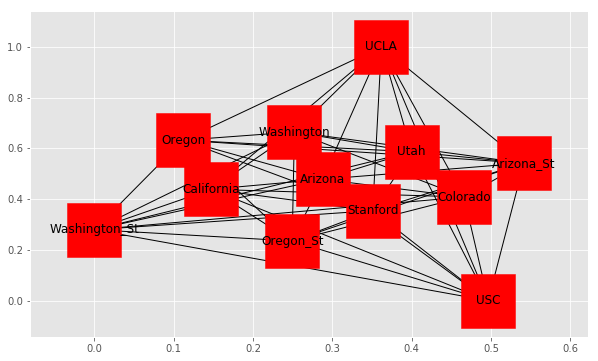

In [21]:
# make graph
Lap = np.dot(np.transpose(B),B)
adj = -Lap + np.diag(np.diag(Lap))
game_graph = nx.from_numpy_matrix(adj)

# Calculate the layout positions first
pos = nx.spring_layout(game_graph)

# labeling needs a dictionary
label_dict = {i:j for i,j in enumerate(P12_teams['team'].tolist())}

# draw graph
nx.draw_networkx(game_graph, pos=pos, node_size=3000, labels = label_dict, node_shape='s')
plt.show()


## Elections and Arrow's impossibility theorem 

``` "At a Lawn Tennis Tournament where I chanced, some while ago, to be a spectator, the present method of assigning prizes was brought to my notice by the lamentations of one of the Players, who had been beaten (and had thus lost all chance of a prize) early in the contest, and who had had the mortification of seeing the 2nd prize carried off by a Player whom he knew to be quite inferior to himself." 
``` ---Charles Dodgson a.k.a Lewis Carroll (1883) 

### Elections vs. winner selection
We define an *election procedure* as a method for generating a ranking (ordering) of a set of candidates from voter preferences. Note that an election does not just name the top candidate, but instead, ranks all of the candidates. (This slightly differs from everyday usage.) We refer to a procedure that only decides the top candidate as a *winner selection method*. 

What is the relationship between these two problems? Clearly, one could recursively use a winner selection method   to define an election procedure. (First choose a winner, then remove the winner from the ballot and use the winner selection method to choose the runner-up, *etc*...) Conversely, the number one ranked alternative in an election procedure can be considered the winner, so every election procedure generates a winner selection method. So are these two problems---elections and winner selection---really equivalent? No, there are election procedures which cannot be derived from recursively selecting a winner.  Thus, election procedures are more general and winner selection methods should be considered a subset of election

First, note that if there are only two candidates, then the  election and winner-selection methods are the same. In this case,  any reasonable method will select the candidate for which the *majority* of the electorate favors.  In the following discussion, we'll assume that there are three or more candidates. The interesting case arises when no single candidate receives a majority of the votes. 

**Examples:**  In the U. S., elections are generally decided by the plurality method or some variation thereof. (Presidential elections in the U.S. involve the electoral college, but I'm not going to discuss this here.) In the *plurality method*, each voter votes for a single candidate and the candidate with the most votes is declared the winner. It often occurs that the candidate does not receive a majority of the votes.  For example, George W. Bush was elected president in 2000 with 47.87% of the votes and Bill Clinton was elected president in 1992 with 43.01% of the votes. In both cases, "third-party" candidates (Ralph Nader and Ross Perot respectively) prevented the winner (or, possibly, the runner-up) from receiving a majority vote. Other voting methods may have resulted in alternative  outcomes in these two elections. For example, in France, Russia, and Brazil, a *runoff election* is held, in which only the top two candidates appear on the ballot. This idea can be further generalized to an election procedure called the *elimination method*, where the candidate with the smallest number of votes is removed from the ballot in each round. This method is used by the International Olympic Committee to select the host for the Olympic games. 

### Election methods
We write $a,b,c,\ldots$ to denote candidates and $i,j,k,\ldots$ to denote voters. 
Each voter has his/her own preferences. We write 
$a \succ_i b$
if candidate $a$ is preferred to candidate $b$ by voter $i$. If voter $i$ has no preference over candidates $a$ and $b$, we write $a=_i b$. Finally we write 
$a \succeq_i b$
to indicate that candidate $b$ is not preferred to candidate $a$ by voter $i$; that is, either: $a\succ_i b$ or $a=_i b$.  We require the voter preferences to satisfy the following relationships:
1. For each pair of candidates, $a$ and $b$,  exactly one of the following holds: $a\succ_i b$, $b\succ_i a$, or $a=_i b$. 
+ For all candidates $a$, $a=_i a$. 
+ Each voter ranking should give a transitive relation: $a \succeq_i b$ and $b \succeq_i c$ implies that $a \succeq_i c$ 
with $a=_i c$ if and only if $a=_i b$ and $b=_i c$. 

An *election method* is a method for generating a ranking of the candidates from the voter preferences that satisfy the above three properties. The relationships generated by the election procedure are  denoted by $\succ$, $=$, and $\succeq$. 

There are many different election methods, for example, the [Borda count](https://en.wikipedia.org/wiki/Borda_count) and [Copeland](https://en.wikipedia.org/wiki/Copeland%27s_method) methods. It can be shown that these methods have drastically different properties. 

**Example:** 
We say that a candidate is a *Condorcet candidate* if he beats every other candidate in head-to-head competition (that is, with all other candidates removed from the ballot).  It is not difficult to show that a Condorcet candidate does not necessarily exist, but if one does, it is unique. Intuitively it would seem desirable for a winner selection method to select the Condorcet candidate, if one exists. One can show that the Copeland  method has the property but the Borda count does not. 

This might prompt us to write down a list of desirable properties and then see which election methods satisfy which properties. 

![http://en.wikipedia.org/wiki/Voting_system](ElectionMethodProperties.png)

Each row of the table is an election method and each column is a desirable property. The entries of the table indicate whether or not the election method satisfies that property. Don't worry about how we define all of these methods or all of the properties. Note that Plurality, Runoff voting, Borda count, and Copeland are among the methods compared and  that the Condorcet property is the third column in the table. 


Looking at this table, we observe that none of the election methods satisfy all of the (desirable) properties. Of course, tomorrow someone could invent a new election method and we could then check to see which of these properties hold for that method.  This leads us to the following question: is it possible that there exists a method that  satisfies all (or possibly a chosen subset) of these properties?  

### Arrow's impossibility theorem
In the following, we define five sensible criteria which we expect a fair and reasonable  election procedure should satisfy. Surprisingly, in 1963, Kenneth Arrow proved that there does not exist an election procedure which can satisfy all five criteria. 

We say an election procedure is *fair* if it satisfies the following five criteria:
1. All conceivable voter rankings are allowed. 
+ If $a \succeq_i b$ for all voters $i$, then $a\succeq b$ with equality if and only if $a=_i b$ for all voters $i$. We interpret this to mean that unanimous opinions are respected. 
+ If in two different elections, each voter ranks candidates $a$ and $b$ the same, then the election outcomes between $a$ and $b$ are the same in the two elections. That is, how candidates are ranked relative to each other in an election depends only on how the voters rank them relative to each other and not how they are ranked relative to other candidates. Denoting preferences in the second election by the symbol $\supseteq$, we express this property in symbols: 
$$
 \text{If} \ \forall i, \ a\succeq_i b \ \iff \ a\supseteq_i b, \quad  \text{then} \ a\succeq b \iff a \supseteq b.  
$$
+ If there are two elections such that $a\succeq_i b$ implies $a \supseteq_i b$ for all $i$, and if also $a \succeq b$, then $a\supseteq b$. In other words, if $a$ does at least as well as $b$ in a later ranking by the voters as he did in the present ranking, and if he beat $b$ in the present election, he'll beat $b$ in the later election. 
+  There is no voter $i$ such that $a\succ b$ if and only if $a\succ_i b$. In other words, there is no dictator. 

To illustrate the absurdity that the presence of the third option should not influence the voters preference between the other two, we consider the following anecdote attributed to Sidney Morgenbesser. 
```
After finishing his meal, a diner decides to order dessert from a restaurant. The waitress tells him he has two choices: apple pie and blueberry pie. The diner orders the apple pie. After a few minutes the waitress returns and says that they also have cherry pie at which point the diner says: "In that case I'll have the blueberry pie."
```

**Arrow's Impossibility Theorem.** No election procedure for three or more candidates is fair. 

In practice, one has to be very careful when considering the method used for an election. No method is fair and, at worse, the method can be exploited by a coalition of the voters. 
